In [1]:
import warnings; warnings.filterwarnings('ignore')
import matplotlib, tarfile, shutil, os, glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
from IPython.display import HTML
HTML('''<script> code_show=true; 
function code_toggle() {
 if (code_show){$('div.input').hide();}
 else {$('div.input').show();}
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script> To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')                             

# Scale Workers
Maybe a work manager can only support 500 Workers (16 node) and not 1000 Workers (64 node).

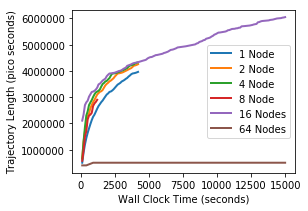

In [50]:
names = {"0": "Splicer", "1": "Worker", "2": "PersistentDB",
         "3": "InMemoryDB", "4": "WorkManager", -1: "all ranks"}

def untar(fname):
    try: shutil.rmtree("tmp")
    except: pass
    os.mkdir("tmp")
    tar = tarfile.open(fname)
    tar.extractall()
    tar.close()

def plot_times(ax, label, results):
    if os.path.exists(results + "/times.out"):
        df = pd.read_csv(results + "/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    else:
        untar(results + "/times.tar.gz")
        shutil.move("times.out", "tmp/times.out")                
        df = pd.read_csv("tmp/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    ax.plot(df["wc"], df["traj"], label=label, lw=2)
    ax.set_ylabel("Trajectory Length (pico seconds)")
    ax.set_xlabel("Wall Clock Time (seconds)")
    ax.legend()

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
d = "../experiments/baseline-trinitite/"
plot_times(ax, "1 Node", d+"nano/sepminima/scale-workers-1-71033")
plot_times(ax, "2 Node", d+"nano/sepminima/scale-workers-2-71035")
plot_times(ax, "4 Node", d+"nano/sepminima/scale-workers-4-71036")
plot_times(ax, "8 Node", d+"nano/sepminima/scale-workers-8-71037")
plot_times(ax, "16 Nodes", d+"nano/scale-workers/scale-workers-16-71161")
plot_times(ax, "64 Nodes", d+"nano/scale-workers/scale-workers-64-71162")

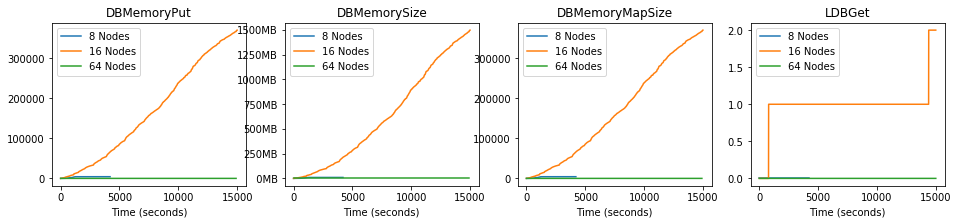

In [3]:
def plot_keyspace(ax, op, results, rank="1", label=""):
    fname = ""
    untar(results + "/out/perf.tar.gz")
    shutil.move("perf/perf." + rank, "tmp/perf." + rank)
    fname = "tmp/perf." + rank
    df = pd.read_csv(fname, names=['ts', 'op', 'count'])
    
    #ax.set_title("# Keys (y1) vs. Size of Data (y2)")
    df_op = df[df['op'] == op]
    shift = np.min(df_op['ts']) * np.ones(len(df_op['ts']))
    if label == "":
        label = os.path.basename(results).split('-')[2] + " Nodes"
    ax.plot(df_op['ts'].astype(float) - shift, df_op['count'].astype(float), label=label)
    ax.set_xlabel("Time (seconds)")
    ax.set_title(op)
    ax.legend()
    
fig, ax = plt.subplots(1, 4, figsize=(16, 3))
d = "../experiments/baseline-trinitite/"
for run in ["nano/sepminima/scale-workers-8-71037",
            "nano/scale-workers/scale-workers-16-71161",
            "nano/scale-workers/scale-workers-64-71162"]:
    plot_keyspace(ax[0], "DBMemoryPut", d+run)
    plot_keyspace(ax[1], "DBMemorySize", d+run)
    plot_keyspace(ax[2], "DBMemoryMapSize", d+run)
    plot_keyspace(ax[3], "LDBGet", d+run, rank="2")

x = ax[1].set_yticklabels(['{:3.0f}MB'.format(yval/(1000*1000)) for yval in ax[1].get_yticks()])

## How does delay affect memory pressure?
## 8 nodes, delay 100K

1 keys, opLDBGet=0.055473965287
1 keys, opDBMemorySize=0.165554072096
100 keys, opLDBGet=0.0666043780032
100 keys, opDBMemorySize=21.1397304151
1000 keys, opLDBGet=0.0483849439402
1000 keys, opDBMemorySize=247.230009345
10000 keys, opLDBGet=0.000667512182097
10000 keys, opDBMemorySize=2663.99733066
unlimited keys, opLDBGet=0.000133466800133
unlimited keys, opDBMemorySize=67459.5086782


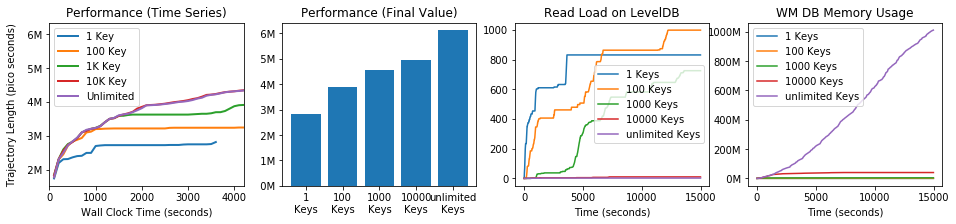

In [37]:
fig, ax = plt.subplots(1, 4, figsize=(16, 3))
d = "../experiments/baseline-trinitite/"
plot_times(ax[0], "1 Key",   d+"nano/scale-workers-and-delay/scale-cachelimit-8n-1-71233")
plot_times(ax[0], "100 Key", d+"nano/scale-workers-and-delay/scale-cachelimit-8n-100-71234")
plot_times(ax[0], "1K Key",  d+"nano/scale-workers-and-delay/scale-cachelimit-8n-1000-71235")
plot_times(ax[0], "10K Key", d+"nano/scale-workers-and-delay/scale-cachelimit-8n-10000-71236")
plot_times(ax[0], "Unlimited", d+"nano/scale-workers-and-delay/scale-cachelimit-8n-unlimited-71237")
ax[0].set_yticklabels(['{:3.0f}M'.format(yval/(1000*1000)) for yval in ax[0].get_yticks()])
ax[0].set_xlim(0, 4200)

def get_max_traj(results):
    if os.path.exists(results + "/times.out"):
        df = pd.read_csv(results + "/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    else:
        untar(results + "/times.tar.gz")
        shutil.move("times.out", "tmp/times.out")                
        df = pd.read_csv("tmp/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    return df.tail(1)

trajs = []
label = []
for run in [d+"nano/scale-workers-and-delay/scale-cachelimit-8n-1-71233",
            d+"nano/scale-workers-and-delay/scale-cachelimit-8n-100-71234",
            d+"nano/scale-workers-and-delay/scale-cachelimit-8n-1000-71235",
            d+"nano/scale-workers-and-delay/scale-cachelimit-8n-10000-71236",
            d+"nano/scale-workers-and-delay/scale-cachelimit-8n-unlimited-71237"]:
    df = get_max_traj(run)
    trajs.append(df['traj'])
    label.append(os.path.basename(run).split('-')[3] + "\nKeys")
    plot_keyspace(ax[2], "LDBGet", run, rank="2", label=os.path.basename(run).split('-')[3] + " Keys")
    plot_keyspace(ax[3], "DBMemorySize", run, rank="1", label=os.path.basename(run).split('-')[3] + " Keys")    

ax[0].set_title("Performance (Time Series)")

ax[1].set_title("Performance (Final Value)")
ax[1].bar(range(0, len(trajs)), trajs)
ax[1].set_xticks(range(0, len(trajs)))
ax[1].set_xticklabels(label)
ax[1].set_yticklabels(['{:3.0f}M'.format(yval/(1000*1000)) for yval in ax[1].get_yticks()])
ax[2].set_title("Read Load on LevelDB")
ax[3].set_title("WM DB Memory Usage")
ax[3].set_yticklabels(['{:3.0f}M'.format(yval/(1000*1000)) for yval in ax[3].get_yticks()])

## The Worst Policy Ever: Increase Cache Size @7K

71497 keys, opLDBPut=2.03989551175
71497 keys, opLDBGet=0.000474946568511
71497 keys, opDBMemoryPut=2.067695962
71511 keys, opLDBPut=2.20640229336
71511 keys, opLDBGet=0.0434782608696
71518 keys, opLDBPut=2.0750357313
71518 keys, opLDBGet=0.0778942353502
71516 keys, opLDBPut=0.0279569892473
71516 keys, opLDBGet=0.110394265233


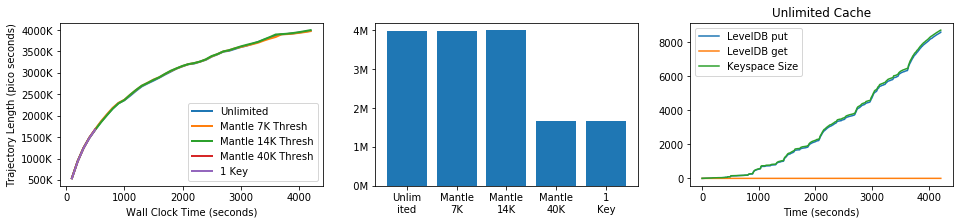

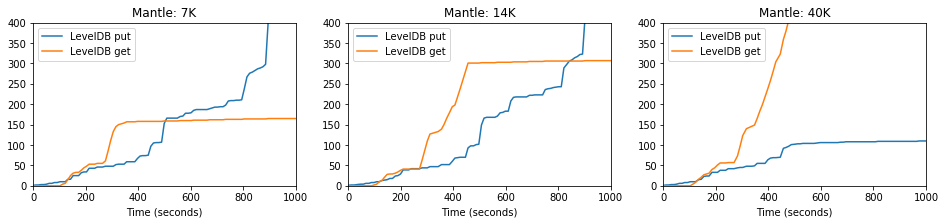

In [143]:
fig, ax = plt.subplots(1, 3, figsize=(16, 3))
d = "../experiments/baseline-trinitite/"
plot_times(ax[0], "Unlimited",         d+"nano/dynpolicies/scale-mantle-unlimited-71497")
plot_times(ax[0], "Mantle 7K Thresh",  d+"nano/dynpolicies/scale-mantle-1-71511")
plot_times(ax[0], "Mantle 14K Thresh", d+"nano/dynpolicies/scale-mantle-1-71518")
plot_times(ax[0], "Mantle 40K Thresh", d+"nano/dynpolicies/scale-mantle-1-71516")
plot_times(ax[0], "1 Key",             d+"nano/dynpolicies/scale-mantle-1-71489")
ax[0].set_yticklabels(['{:3.0f}K'.format(yval/(1000)) for yval in ax[0].get_yticks()])

trajs = []
label = ["Unlim\nited", "Mantle\n7K", "Mantle\n14K", "Mantle\n40K", "1\nKey"]
for run in [d+"nano/dynpolicies/scale-mantle-unlimited-71497",
            d+"nano/dynpolicies/scale-mantle-1-71511",
            d+"nano/dynpolicies/scale-mantle-1-71518",
            d+"nano/dynpolicies/scale-mantle-1-71516",
            d+"nano/dynpolicies/scale-mantle-1-71489"]:
    df = get_max_traj(run)
    trajs.append(df['traj'])
ax[1].bar(range(0, len(trajs)), trajs)
ax[1].set_xticks(range(0, len(trajs)))
ax[1].set_xticklabels(label)
ax[1].set_yticklabels(['{:3.0f}M'.format(yval/(1000*1000)) for yval in ax[1].get_yticks()])

plot_keyspace(ax[2], "LDBPut", d+"nano/dynpolicies/scale-mantle-unlimited-71497", rank="2", label="LevelDB put")
plot_keyspace(ax[2], "LDBGet", d+"nano/dynpolicies/scale-mantle-unlimited-71497", rank="2", label="LevelDB get")
plot_keyspace(ax[2], "DBMemoryPut", d+"nano/dynpolicies/scale-mantle-unlimited-71497", label="Keyspace Size")
ax[2].set_title("Unlimited Cache")

fig, ax = plt.subplots(1, 3, figsize=(16, 3))
plot_keyspace(ax[0], "LDBPut", d+"nano/dynpolicies/scale-mantle-1-71511", rank="2", label="LevelDB put")
plot_keyspace(ax[0], "LDBGet", d+"nano/dynpolicies/scale-mantle-1-71511", rank="2", label="LevelDB get")
ax[0].set_title("Mantle: 7K")

plot_keyspace(ax[1], "LDBPut", d+"nano/dynpolicies/scale-mantle-1-71518", rank="2", label="LevelDB put")
plot_keyspace(ax[1], "LDBGet", d+"nano/dynpolicies/scale-mantle-1-71518", rank="2", label="LevelDB get")
ax[1].set_title("Mantle: 14K")

plot_keyspace(ax[2], "LDBPut", d+"nano/dynpolicies/scale-mantle-1-71516", rank="2", label="LevelDB put")
plot_keyspace(ax[2], "LDBGet", d+"nano/dynpolicies/scale-mantle-1-71516", rank="2", label="LevelDB get")
ax[2].set_title("Mantle: 40K")

#plot_keyspace(ax[4], "LDBPut", d+"nano/dynpolicies/scale-mantle-1-71489", rank="2", label="LevelDB put")
#plot_keyspace(ax[4], "LDBGet", d+"nano/dynpolicies/scale-mantle-1-71489", rank="2", label="LevelDB get")
#ax[4].set_title("1 Key Cache")

for a in range(0, len(ax)):
    ax[a].set_xlim(0, 1000)
    ax[a].set_ylim(0, 400)

## Is this consistent?
Check the 1 node, 1 hour case.

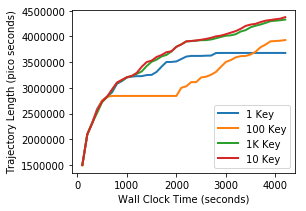

In [6]:
def plot_times(ax, label, results):
    if os.path.exists(results + "/times.out"):
        df = pd.read_csv(results + "/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    else:
        untar(results + "/times.tar.gz")
        shutil.move("times.out", "tmp/times.out")                
        df = pd.read_csv("tmp/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    ax.plot(df["wc"], df["traj"], label=label, lw=2)
    ax.set_ylabel("Trajectory Length (pico seconds)")
    ax.set_xlabel("Wall Clock Time (seconds)")
    ax.legend()

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
d = "../experiments/baseline-trinitite/"
plot_times(ax, "1 Key", d+"nano/purge-keys-working/scale-cachelimit-1-71157")
plot_times(ax, "100 Key", d+"nano/purge-keys-working/scale-cachelimit-100-71158")
plot_times(ax, "1K Key", d+"nano/purge-keys-working/scale-cachelimit-1000-71159")
plot_times(ax, "10 Key", d+"nano/purge-keys-working/scale-cachelimit-10000-71160")

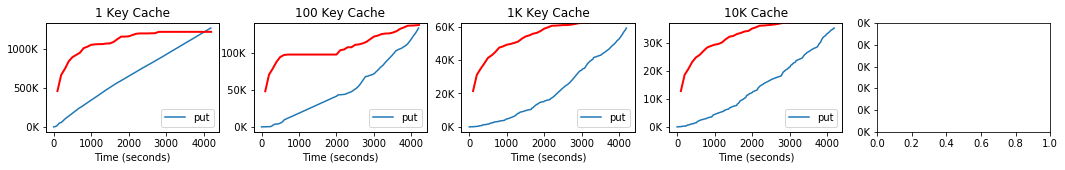

In [7]:
def plot_times(ax, label, results):
    if os.path.exists(results + "/times.out"):
        df = pd.read_csv(results + "/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    else:
        untar(results + "/times.tar.gz")
        shutil.move("times.out", "tmp/times.out")                
        df = pd.read_csv("tmp/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    ax.plot(df["wc"], df["traj"], label=label, lw=2, color='r')
    ax.set_yticks([])
    ax.set_ylim(0, 4000000)

fig, ax = plt.subplots(1, 5, figsize=(18, 2))
d = "../experiments/baseline-trinitite/"

run = d+"nano/purge-keys-working/scale-cachelimit-1-71157"
plot_times(ax[0].twinx(), "1 Key", run)
plot_keyspace(ax[0], "DBMemoryPut", run, label="put")
ax[0].set_title("1 Key Cache")

run = d+"nano/purge-keys-working/scale-cachelimit-100-71158"
plot_times(ax[1].twinx(), "1 Key", run)
plot_keyspace(ax[1], "DBMemoryPut", run, label="put")
ax[1].set_title("100 Key Cache")

run = d+"nano/purge-keys-working/scale-cachelimit-1000-71159"
plot_times(ax[2].twinx(), "1 Key", run)
plot_keyspace(ax[2], "DBMemoryPut", run, label="put")
ax[2].set_title("1K Key Cache")

run = d+"nano/purge-keys-working/scale-cachelimit-10000-71160"
plot_times(ax[3].twinx(), "1 Key", run)
plot_keyspace(ax[3], "DBMemoryPut", run, label="put")
ax[3].set_title("10K Cache")

for x in range(0, len(ax)):
    ax[x].legend(loc='lower right')
    #ax[x].set_xlim(0, 1000)
    #ax[x].set_ylim(0, 200000)
    ax[x].set_yticklabels(['{:3.0f}K'.format(yval/(1000)) for yval in ax[x].get_yticks()])
 